# Confronto tra DGF-PTTOT e DGF-PTTOT-S
Di seguito, confrontiamo il modello ottimizzato (HP tuning con 100 esperimenti) usando tutto il dataset per DGF-PTTOT e il modello ottimizzato usando il sottoinsieme del precedente dataset (HP tuning con 100 esperimenti). Entrambi i modelli sono riaddestrati e testati usando rispettivamente il training e il test set completo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cosmo_dlp.model import CosmoData, CosmoPredictor
import pickle
import io
import yaml
import seaborn as sns
import numpy as np
import os.path
sns.set_theme(style="whitegrid")

train_df = pd.read_csv("data/input/DGF_PTTOT_train.csv")
test_df = pd.read_csv("data/input/DGF_PTTOT_test.csv")
all_df = pd.concat([train_df, test_df])

Addestro il modello DGF-PTTOT (o carico i risultati, se l'ho già eseguito):

In [2]:
train_res_tot_file = "data/output/DGF_PTTOT_train_result.csv"
test_res_tot_file = "data/output/DGF_PTTOT_test_result.csv"

if os.path.exists(train_res_tot_file) and os.path.exists(test_res_tot_file):
    print("Carico i risultati del modello da file")
else:
    with open("data/hpopt/DGF_PTTOT.pk", "rb") as fp:
        trials = pickle.load(fp)
        best = trials.best_trial
        
    config = best["result"]["config"]
    cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
    best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
    
    data = CosmoData(train_df, None, test_df, config["batch"])
    model = CosmoPredictor(data.input_size, config)
    train_res_tot = model.fit(data, best_epoch)
    test_res_tot = model.test(data)
    train_res_tot.to_csv(train_res_tot_file, index=False)
    test_res_tot.to_csv(test_res_tot_file, index=False)
    
train_res_tot = pd.read_csv(train_res_tot_file)
test_res_tot = pd.read_csv(test_res_tot_file)

Carico i risultati del modello da file


Addestro il modello DGF-PTTOT-S (o carico i risultati, se l'ho già eseguito):

In [3]:
train_res_par_file = "data/output/DGF_PTTOT_S_ALL_train_result.csv"
test_res_par_file = "data/output/DGF_PTTOT_S_ALL_test_result.csv"

if os.path.exists(train_res_par_file) and os.path.exists(test_res_par_file):
    print("Carico i risultati del modello da file")
else:
    with open("data/hpopt/DGF_PTTOT_S.pk", "rb") as fp:
        trials = pickle.load(fp)
        best = trials.best_trial
        
    config = best["result"]["config"]
    cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
    best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
    
    data = CosmoData(train_df, None, test_df, config["batch"])
    model = CosmoPredictor(data.input_size, config)
    train_res_par = model.fit(data, best_epoch)
    test_res_par = model.test(data)
    train_res_par.to_csv(train_res_par_file, index=False)
    test_res_par.to_csv(test_res_par_file, index=False)
    
train_res_par = pd.read_csv(train_res_par_file)
test_res_par = pd.read_csv(test_res_par_file)

Carico i risultati del modello da file


Possiamo notare come il modello DGF-PTTOT-S si comporti in modo lievemente peggiore ma analogo rispetto al modello DGF-PTTOT.

In [4]:
test_res_tot["abs_err"] = (test_res_tot.target - test_res_tot.prediction).abs()
test_res_tot["rel_err"] = test_res_tot.abs_err / test_res_tot.target
test_res_tot["residual"] = test_res_tot.target - test_res_tot.prediction
test_res_tot[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,160073.000000,1.600730e+05
mean,33.747999,2.875299e-02
std,121.375019,4.941044e-02
min,0.000076,4.512699e-07
25%,2.755844,7.981233e-03
50%,9.364975,1.740951e-02
75%,30.666260,3.247521e-02
max,6354.672852,7.881131e-01


In [5]:
test_res_par["abs_err"] = (test_res_par.target - test_res_par.prediction).abs()
test_res_par["rel_err"] = test_res_par.abs_err / test_res_par.target
test_res_par["residual"] = test_res_par.target - test_res_par.prediction
test_res_par[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,160073.000000,160073.000000
mean,42.448131,0.036577
std,128.522417,0.059409
min,0.000000,0.000000
25%,3.769028,0.011110
50%,12.694214,0.023711
75%,40.907349,0.041882
max,6503.326172,0.927649


In [6]:
for name, df in zip(("DGF-PTTOT", "DGF-PTTOT-S"), (test_res_tot, test_res_par)):
    print(f"MAE {name}:", df.abs_err.mean())

MAE DGF-PTTOT: 33.74799880056103
MAE DGF-PTTOT-S: 42.44813096755488


In [7]:
for name, df in zip(("DGF-PTTOT", "DGF-PTTOT-S"), (test_res_tot, test_res_par)):
    print(f"RMSE {name}:", np.sqrt((df.abs_err ** 2).mean()))

RMSE DGF-PTTOT: 125.97908768537681
RMSE DGF-PTTOT-S: 135.35047945377536


In [8]:
for name, df in zip(("DGF-PTTOT", "DGF-PTTOT-S"), (test_res_tot, test_res_par)):
    print(f"MAPE {name}:", 100 * df.rel_err.mean())

MAPE DGF-PTTOT: 2.8752986290800604
MAPE DGF-PTTOT-S: 3.6576895166208274


Notiamo come i pattern nella correlazione tra tempo di esecuzione e errore assoluto/relativo siano molto simili. I vari pattern presenti nei grafici sono delle anomalie, come emerso da [DGF-PTTOT.ipynb](DGF-PTTOT.ipynb) e quindi significa che entrambi i modelli riconoscono le anomalie.

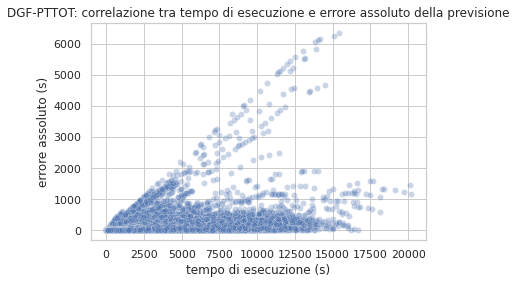

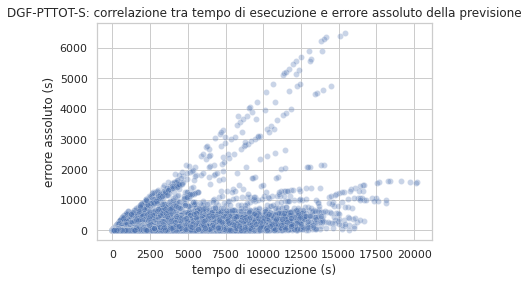

In [9]:
for name, df in zip(("DGF-PTTOT", "DGF-PTTOT-S"), (test_res_tot, test_res_par)):
    sns.scatterplot(data=df, x="target", y="abs_err", alpha=0.3)
    plt.title(f"{name}: correlazione tra tempo di esecuzione e errore assoluto della previsione")
    plt.xlabel("tempo di esecuzione (s)")
    plt.ylabel("errore assoluto (s)")
    plt.show()

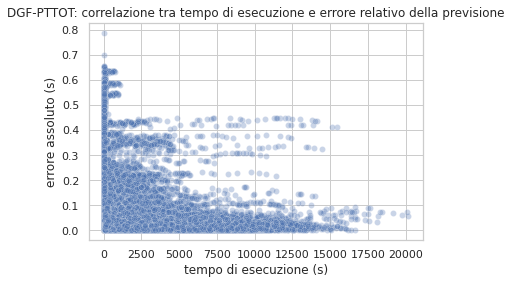

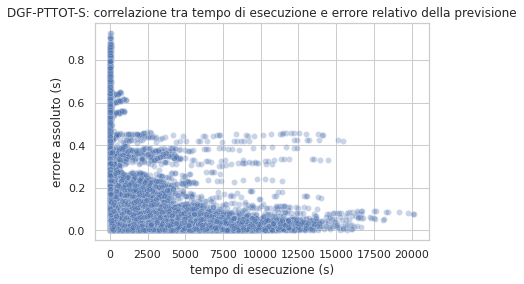

In [10]:
for name, df in zip(("DGF-PTTOT", "DGF-PTTOT-S"), (test_res_tot, test_res_par)):
    sns.scatterplot(data=df, x="target", y="rel_err", alpha=0.3)
    plt.title(f"{name}: correlazione tra tempo di esecuzione e errore relativo della previsione")
    plt.xlabel("tempo di esecuzione (s)")
    plt.ylabel("errore assoluto (s)")
    plt.show()

Anche analizzando la distribuzione dell'errore notiamo una forte somiglianza.

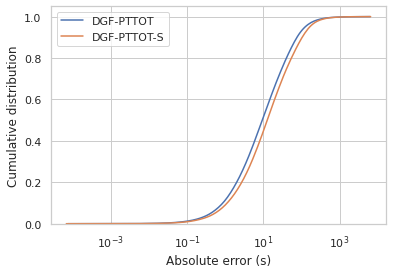

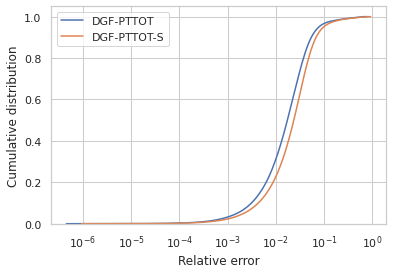

In [11]:
for name, df in zip(("DGF-PTTOT", "DGF-PTTOT-S"), (test_res_tot, test_res_par)):
    sns.kdeplot(data=df.query("abs_err > 0"), x="abs_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgf-pttot-pttot-s/cdf-errore-assoluto.pdf")
plt.show()

for name, df in zip(("DGF-PTTOT", "DGF-PTTOT-S"), (test_res_tot, test_res_par)):
    sns.kdeplot(data=df.query("rel_err > 0"), x="rel_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.xlabel("Relative error")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgf-pttot-pttot-s/cdf-errore-relativo.pdf")
plt.show()

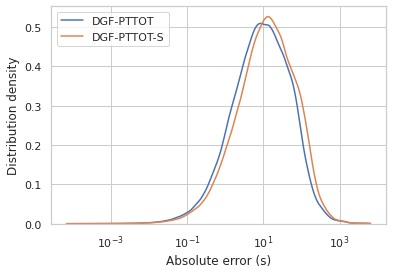

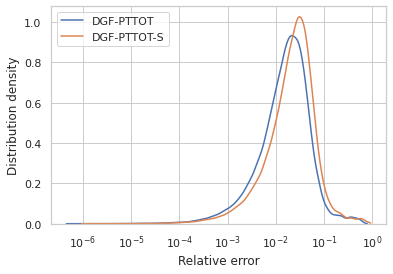

In [12]:
for name, df in zip(("DGF-PTTOT", "DGF-PTTOT-S"), (test_res_tot, test_res_par)):
    sns.kdeplot(data=df.query("abs_err > 0"), x="abs_err", log_scale=True, cumulative=False, cut=0, label=name)
    
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Distribution density")
plt.savefig("tex/images/dgf-pttot-pttot-s/pdf-errore-assoluto.pdf")
plt.show()

for name, df in zip(("DGF-PTTOT", "DGF-PTTOT-S"), (test_res_tot, test_res_par)):
    sns.kdeplot(data=df.query("abs_err > 0"), x="rel_err", log_scale=True, cumulative=False, cut=0, label=name)
    
plt.xlabel("Relative error")
plt.ylabel("Distribution density")
plt.legend()
plt.savefig("tex/images/dgf-pttot-pttot-s/pdf-errore-relativo.pdf")
plt.show()

Da notare che il modello DGF-PTTOT ha un hidden layer in meno (2 invece che 3), un learning rate di quasi un terzo e un weight decay quasi triplo rispetto a DGF-PTTOT-S.

In [13]:
with open("data/hpopt/DGF_PTTOT.pk", "rb") as fp:
    trials = pickle.load(fp)
    best = trials.best_trial
        
    config = best["result"]["config"]
    print("Modello DGF-PTTOT")
    print(yaml.dump(config))
    
with open("data/hpopt/DGF_PTTOT_S.pk", "rb") as fp:
    trials = pickle.load(fp)
    best = trials.best_trial
        
    config = best["result"]["config"]
    print("Modello DGF-PTTOT-S")
    print(yaml.dump(config))

Modello DGF-PTTOT
batch: 256
epochs: 500
kfold: 10
loss: mae
model:
  layers: !!python/tuple
  - dropout: 0.0
    size: 38
  - dropout: 0.0
    size: 31
optimizer:
  lr: 0.0010018009851965168
  name: adam
  weight_decay: 0.0918103596185136

Modello DGF-PTTOT-S
batch: 64
epochs: 500
kfold: 10
loss: mae
model:
  layers: !!python/tuple
  - dropout: 0.0
    size: 41
  - dropout: 0.0
    size: 34
  - dropout: 0.0
    size: 30
optimizer:
  lr: 0.0027492197716492872
  name: adam
  weight_decay: 0.03264538360271234



## Conclusioni
I due modelli hanno prestazioni analoghe, ma DGF-PTTOT è lievemente migliore. Si può concludere che il minor numero di dati usato nell'HP tuning di DGF-PTTOT-S non influisce drasticamente sulla qualità del modello, anche se probabilmente influisce la relazione sostanzialmente lineare tra il numero di ore e il tempo di esecuzione per un data configurazione.

Tuttavia, possiamo notare che il tempo speso per l'HP tuning di DGF-PTTOT sia sensibilmente maggiore di quello speso per DGF-PTTOT-S.

Di conseguenza per la scelta di una strategia rispetto all'altra in fase di HTP tuning ci si può basare sul tempo a disposizione per gli esperimenti.

In [14]:
from datetime import timedelta
with open("data/hpopt/DGF_PTTOT.pk", "rb") as fp:
    trials = pickle.load(fp)
    total_time = timedelta(0)
    for t in trials.trials:
        total_time += t["refresh_time"] - t["book_time"]
        
print(f"DGF-PTTOT:   tempo totale HP tuning: {total_time}, tempo medio per esperimento: {total_time/len(trials)}, numero esperimenti: {len(trials)}")

from datetime import timedelta
with open("data/hpopt/DGF_PTTOT_S.pk", "rb") as fp:
    trials = pickle.load(fp)
    total_time = timedelta(0)
    for t in trials.trials:
        total_time += t["refresh_time"] - t["book_time"]
        
print(f"DGF-PTTOT-S: tempo totale HP tuning: {total_time}, tempo medio per esperimento: {total_time/len(trials)}, numero esperimenti: {len(trials)}")

DGF-PTTOT:   tempo totale HP tuning: 15 days, 16:35:09.915000, tempo medio per esperimento: 3:45:57.099150, numero esperimenti: 100
DGF-PTTOT-S: tempo totale HP tuning: 1 day, 22:25:54.817000, tempo medio per esperimento: 0:05:34.309634, numero esperimenti: 500
